# Building the Classifier

In [2]:
import pickle
import pandas as pd
import numpy as np
from os.path import join

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## 1. For a single region

1.1 Read saved feature matrix and corresponding labels

In [ ]:
region = 'curated'

pickle_path = join('..', '..', 'pickles')
with open(join(pickle_path, 'resnet50_avg_features_' + region + '_train.pkl'), 'rb') as f:
    df_train = pickle.load(f)

### 1.2 Convert the features into a matrix and the labels into a list

In [ ]:
feature_matrix = df_train['features'].to_numpy()
feature_matrix = np.column_stack(feature_matrix).transpose()

labels = df_train['label'].to_numpy().astype('int')

scaler = StandardScaler()
scaler.fit(feature_matrix)
feature_matrix_scaled = scaler.transform(feature_matrix)

1.3 Split data into train and validation set

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix_scaled,
                                                                            labels,
                                                                            test_size=0.33,
                                                                            random_state=43)

1.3. Train a classifier on the training set and save it to disk

In [ ]:
clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr')
clf.fit(features_train, labels_train)

#with open(join(pickle_path, 'classifier_densenet201_max.pkl' ), 'wb') as f:
#    pickle.dump(clf, f)

1.4. Predict labels on the validation set according to the classifier

In [ ]:
predicted_labels = clf.predict(features_test)

1.5. Calculate and plot (to do) the confusion matrix

In [ ]:
cm = confusion_matrix(labels_test, predicted_labels)
print(cm)

Train a RF to assess feature importance

In [ ]:

forest = RandomForestClassifier(n_estimators=50, max_depth=16, random_state=0)
forest.fit(feature_matrix, labels) 

In [ ]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1][:1]

In [ ]:
feature_matrix_selected = feature_matrix[:, indices]

In [ ]:
indices

In [ ]:
feature_matrix_selected

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix_selected,
                                                                            labels,
                                                                            test_size=0.33,
                                                                            random_state=43)

clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr')
clf.fit(features_train, labels_train)

predicted_labels = clf.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)
print(cm)

In [ ]:
pred_probas = clf.predict_proba(features_test)

for i in range(len(predicted_labels)):
    print(pred_probas[i], labels_test[i])

## 2. For a set of regions

2.1 Load all available training features into one big dataframe

In [3]:
regions = regions = ['borde_rural', 'mixco_1_and_ebenezer', 'mixco_3', 'dennery']

In [4]:
columns = ['id', 'features', 'label']
df_train_global = pd.DataFrame(columns=columns)

pickle_path = join('..', '..', 'pickles')
for region in regions:
    try:
        with open(join(pickle_path, 'resnet50_avg_features_' + region + '_train.pkl'), 'rb') as f:
            df_train = pickle.load(f)
            df_train_global = pd.concat([df_train_global, df_train], ignore_index=True)
    except:
        print("Error reading training data for region ", region)
    

In [5]:
df_train_global.head()
df_train_global = df_train_global.sort_values(by=['id'])

2.2 Expand the dataframe such that instead of a list of features, every feature has its one column

In [6]:
#features_train = df_train_global.features.apply(lambda features: pd.Series(list(features)))
#features_train

#features_train = df_train_global.features.apply(lambda x: pd.Series(list(x)))
#features_train = features_train.astype('double')

feature_matrix_global = df_train_global['features'].to_numpy()
feature_matrix_global = np.column_stack(feature_matrix_global).transpose()

labels_global = df_train_global['label'].to_numpy().astype('int')

In [7]:
scaler = StandardScaler()
scaler.fit(feature_matrix_global)
feature_matrix_scaled = scaler.transform(feature_matrix_global)

In [8]:
print(feature_matrix_global.shape)
print(labels_global.shape)

(8865, 2048)
(8865,)


## 3. Train an SVM Classifier

In [ ]:
clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr', verbose=1)
clf.fit(feature_matrix_global, labels_global)

In [ ]:
#with open(join(pickle_path, 'classifier_resnet50_avg_retrained_all_scaled.pkl' ), 'wb') as f:
#    pickle.dump(clf, f)

## 4. Train a Random Forest Model

In [9]:
forest = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=0, n_jobs=6)
forest.fit(feature_matrix_global, labels_global) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [10]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1][:20]
feature_matrix_selected = feature_matrix_global[:, indices]

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix_selected,
                                                                            labels_global,
                                                                            test_size=0.33,
                                                                            random_state=42)

clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr')
clf.fit(features_train, labels_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [12]:
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

In [13]:
predicted_labels = clf.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / row_sums

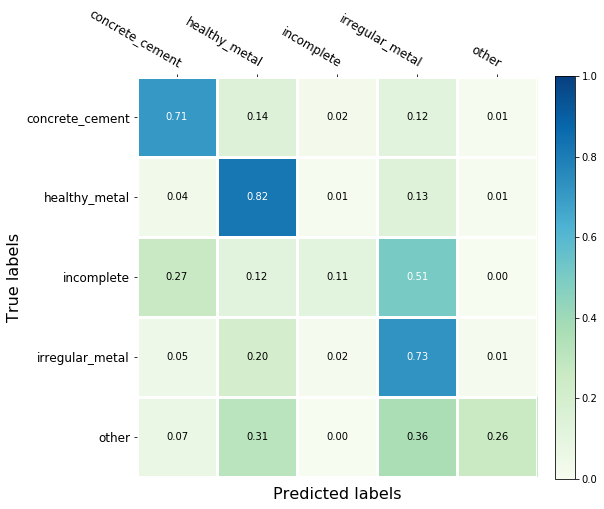

In [15]:
import matplotlib.pyplot as plt
import utils

fig, ax = plt.subplots(figsize=(8.5, 8.5))
im, cbar = utils.heatmap(cm_norm,  materials.keys(), materials.keys(), ax=ax,
                   cmap="GnBu")
texts = utils.annotate_heatmap(im)

fig.tight_layout()
plt.show()

#fname = join('..', 'documentation', 'figures', 'results', 'nn_based_cm.png')
#fig.savefig(fname)

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
cv_results = cross_validate(clf, feature_matrix_selected, labels_global,
                            cv=5, scoring=('f1_macro', 'f1_micro', 'accuracy', 'balanced_accuracy', 'log_loss'),
                            n_jobs=7)

In [ ]:
cv_results